# Week 4: Fourier transform: filtering and sampling

The exercise of this week is about Fourier Transform, image filtering and sampling. First load the following libraries that will be necessary.

In [10]:
!pip3 install scipy
!pip3 install scikit-image

In [11]:
%matplotlib inline

from time import time
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage import convolve
from scipy.fftpack import fft2, ifft2, fftshift
from matplotlib.pyplot import imshow, show, figure
import numpy as np

Load the two images wall.jpg and sidewalk.jpg.

(756, 622)


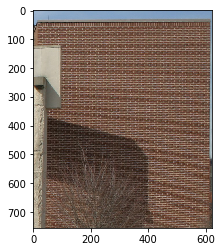

In [60]:
wall = np.array(imread('wall.jpg'), dtype=np.float) / 255.
wall_gray = rgb2gray(wall)
# print(wall_gray.shape)
imshow(wall)

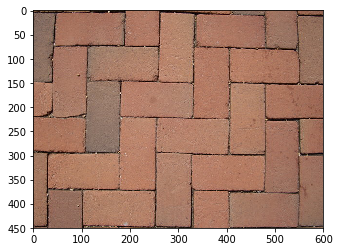

In [13]:
side = np.array(imread('sidewalk.jpg'), dtype=np.float) / 255.
side_gray = rgb2gray(side)
imshow(side)

Preliminary question: which of the two images has the most low pass content? Which one has the most high pass content?

Answer: Maybe it's the blurrier one? Nope, low image frequs = slow gray level changes, high image freqs = fast changes in gray levels (e.g. edges and noises). So, the first one has more high pass content. 

The following functions will be useful in the course of this tutorial: `fft2`, `ifft2`, `convolve` from scipy and the following function:

In [14]:
def gaussian_filter(shape, sigma):
    """
    Returns a 2D gaussian filter specified by its shape and standard deviation.
    """
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

## Part A: Filtering

Create three Gaussian filters:
- one 5x5 Gaussian low pass filter with standard deviation 1
- one 15x15 Gaussian high pass filter with standard deviation $\sigma=3.5$. Hint: the high pass content of an image can be extracted by subtracting the low pass filtered image from the original image. Hence, you can get a high pass filter kernel from a low pass one by subtracting the low pass filter kernel from a unit impulse filter. A unit impulse filter is a filter full of 0s with a single 1 in the middle, that once convolved with an image returns the same image.
- one band pass filter. To do this, create first a 15x15 Gaussian filter with standard deviation 1 and then convolve this low pass filter with the previous high pass filter to create the band pass filter. Indeed, convolution is associative: 
$$
I \ast F_\text{band-pass} = (I \ast F_\text{low-pass}) \ast F_\text{high-pass} = I \ast (F_\text{low-pass} \ast F_\text{high-pass})
$$

You can then visualize your filters in spatial and frequency domains (using `fft2` and `fftshift` from scipy for the latter). Since the filters are complex in the frequency domain, use `np.abs()` to display the magnitude of the filter.

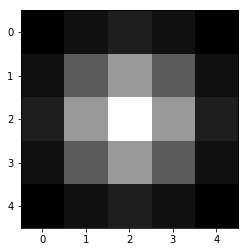

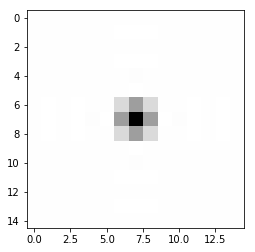

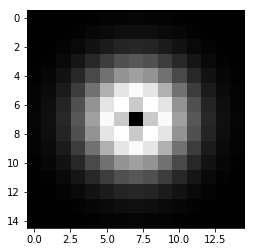

In [43]:
# Low pass filter
# Enter your code here
filter_low = gaussian_filter((5, 5), 1)
imshow(filter_low, cmap='gray')
show()

# High pass filter
# Enter your code here
# filter_high = gaussian_filter((15, 15), 3.5)
identity = np.zeros([15, 15])
identity[7,7] = 1
filter_high = (identity - gaussian_filter((15, 15), 3.5))
imshow(filter_high)
h=fftshift(fft2(filter_high))
imshow(np.abs(h), cmap='gray')
show()

# Band pass filter
# Enter your code here
filter_band = convolve(gaussian_filter((15, 15), 1), filter_high)
h2 = fftshift(fft2(filter_band))
imshow(np.abs(h2), cmap='gray')
show()

Apply these three filters to the two sample grayscale images in spatial domain first by convolving the image with the kernel, and in frequency domain secondly by taking the Fourier tranform of both the image and the filter kernel and multiplying them. Compare the runtimes of spatial and frequency domain filtering, using the `time` function of python. Compare the filtering results of two images by visualizing the filtered images in both spatial and frequency domains. Check that your initial guess about the low/high pass content of the images is correct. NOTE: the time it takes for the convolution of the wall image is higher than the Fourier transform (and stuff) for the side image!

### Filtering in spatial domain

Original image:
0.6387042999267578


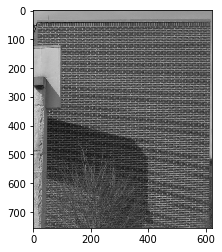

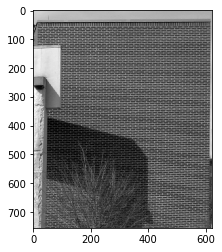

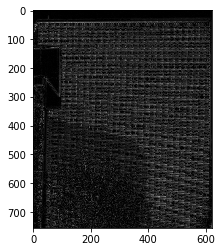

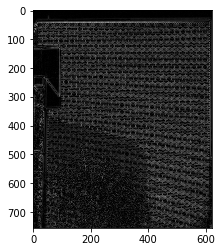

In [58]:
print("Original image:")
imshow(wall_gray, cmap='gray')
show()


start = time()
convol_low = convolve(wall_gray, filter_low)
convol_high = convolve(wall_gray, filter_high)
convol_band = convolve(wall_gray, filter_band)
end = time()
print(end-start)


imshow(np.abs(convol_low), cmap='gray')
show() # makes the picture stay!
imshow(np.abs(convol_high), cmap='gray')
show()
imshow(np.abs(convol_band), cmap='gray')
show()

# Enter your code here

Original image:


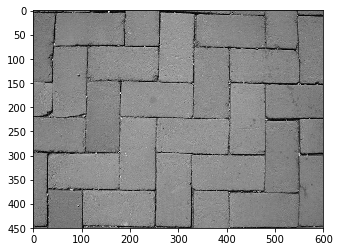

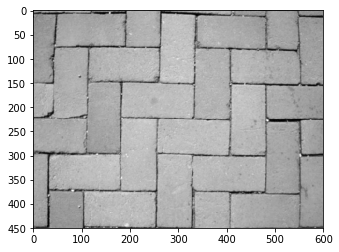

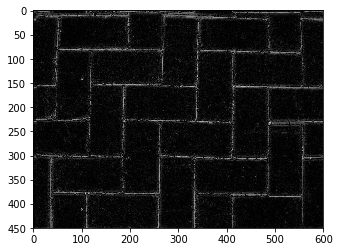

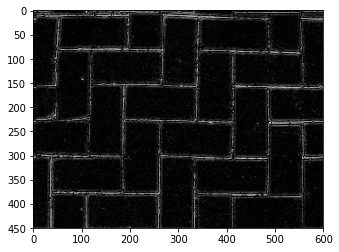

0.31957507133483887


In [59]:
print("Original image:")
imshow(side_gray, cmap='gray')
show()

# do an fft: use fft2()
# do an inverse fft: use ifft2()
# want to shift an fft: use fftshift()

# DON'T use np.reshape(filter_low, side_gray.shape), you DON'T HAVE ENOUGH ELEMENTS FOR THAT
# use the special stuff from fft2 instead!
# you can tell it that you want that size in the end fft2(whatToFFT2, wantedSizeOfResult)
convol_lowF = ifft2(fft2(side_gray) * fft2(filter_low, side_gray.shape))
imshow(np.abs(convol_lowF), cmap='gray')
show()

# high pass
convol_highF = ifft2(fft2(side_gray) * fft2(filter_high, side_gray.shape))
imshow(np.abs(convol_highF), cmap='gray')
show()

# band pass
convol_bandF = ifft2(fft2(side_gray) * fft2(filter_band, side_gray.shape))
imshow(np.abs(convol_bandF), cmap='gray')
show()

# to figure out time it takes
start = time()
convol_lowF = ifft2(fft2(side_gray) * fft2(filter_low, side_gray.shape))
convol_highF = ifft2(fft2(side_gray) * fft2(filter_high, side_gray.shape))
convol_bandF = ifft2(fft2(side_gray) * fft2(filter_band, side_gray.shape))
end = time()
print(end-start)

### Filtering in frequency domain

Note: the output of `ifft2` is a numpy array with complex values with zero imaginary part (up to numerical precision). Extract the real component via the `.real` attribute.

Original image:


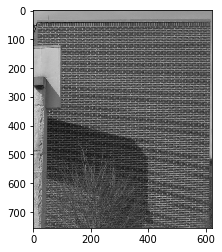

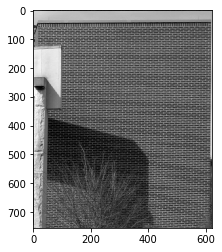

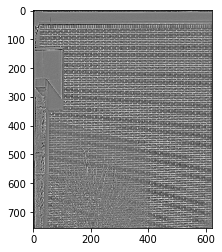

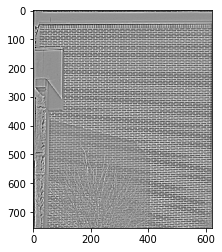

In [55]:
print("Original image:")
imshow(wall_gray, cmap='gray')
show()

convol_wall_lowF = ifft2(fft2(wall_gray) * fft2(filter_low, wall_gray.shape))
imshow(convol_wall_lowF.real, cmap='gray')
show()


# high pass
convol_wall_highF = ifft2(fft2(wall_gray) * fft2(filter_high, wall_gray.shape))
imshow(convol_wall_highF.real, cmap='gray')
show()

# band pass
convol_wall_bandF = ifft2(fft2(wall_gray) * fft2(filter_band, wall_gray.shape))
imshow(convol_wall_bandF.real, cmap='gray')
show()

Original image:


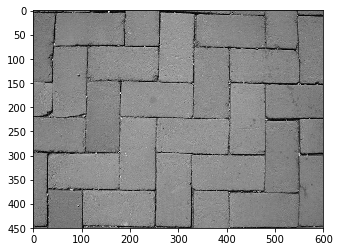

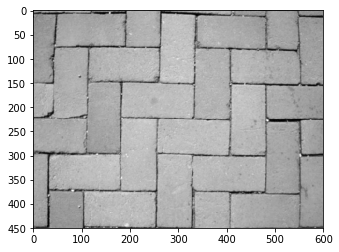

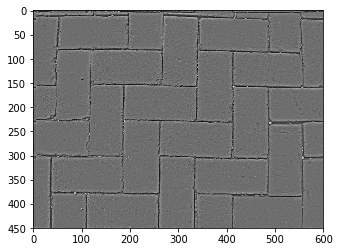

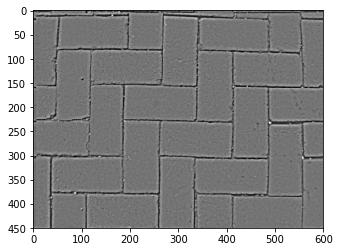

In [54]:
print("Original image:")
imshow(side_gray, cmap='gray')
show()

convol_side_lowF = ifft2(fft2(side_gray) * fft2(filter_low, side_gray.shape))
imshow(convol_side_lowF.real, cmap='gray')
show()


# high pass
convol_side_highF = ifft2(fft2(side_gray) * fft2(filter_high, side_gray.shape))
imshow(convol_side_highF.real, cmap='gray')
show()

# band pass
convol_side_bandF = ifft2(fft2(side_gray) * fft2(filter_band, side_gray.shape))
imshow(convol_side_bandF.real, cmap='gray')
show()

## Part B: Sampling

Downsample both images to one fourth of the resolution by taking every second row and column. You can use numpy array slicing for this: `my_array[start:end:step]`. Compare the results in terms of distortions and unexpected effects. Explain why the quality of the two downsampled images differ. 

(756, 622)


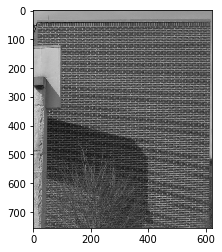

(378, 311)


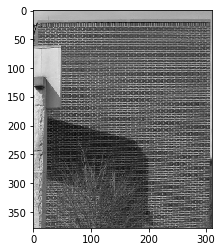

In [70]:
# Enter your code here

# downsampled_wall = wall_gray[(0,0), (wall_gray.shape - (1,1)), (2,2)]
downsampled_wall = wall_gray[0::2, 0::2] # that's a way to take every second col and every second row 

print(wall_gray.shape)
imshow(wall_gray, cmap='gray')
show()

print(downsampled_wall.shape)
imshow(downsampled_wall, cmap = 'gray')
show()

Create three 15x15 Gaussian low pass filters with standard deviations 0.5, 1 and 1.5 and apply them to the color image wall.jpg. You can filter the three channels separately and gather them in an RGB image with the numpy function `np.stack([r_img, g_img, b_img], axis=-1)`. Downsample the three filtered images to one fourth resolution. Compare the resulting downsampled images in terms of quality.

In [ ]:
# Create the filters
# Enter your code here

# Convolve them with the RGB image
# Enter your code here

# Downsample the resulting images
# Enter your code here

## Bonus: for those that finished earlier

Load the blurred road signs image and using your fresh knowledge about filters, design the perfect filter to make the text readable.

In [ ]:
blurred_road_signs = np.array(imread('blurred_road_signs.jpg', as_gray=True), dtype=np.float) / 255.

figure(figsize=(10, 10))
imshow(blurred_road_signs, cmap='gray')
show()

# Exam questions

![alt](exam_questions/Q_B1.png)
![alt](exam_questions/Q_B2_1.png)
![alt](exam_questions/Q_B2_2.png)
![alt](exam_questions/Q_C1.png)
![alt](exam_questions/Q_C2.png)
![alt](exam_questions/Q_C3.png)